This notebook is an example for the polygon dataset made by [labelme](https://github.com/wkentaro/labelme).

You don't need to make background polygon. If there are no polygon in the image, labelme don't export json file, but it's ok.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

Set path to this package's src/

In [2]:
deeplabv3plus_srcdir="./src"
sys.path.append(deeplabv3plus_srcdir)

If you want, write about gpu setting here.

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="0", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
#this block is for debugging.
#import importlib
#importlib.reload(sys.modules['model'])

import from .src/

In [5]:
from model import deeplab_v3plus_transfer_os16
#from image_utils import make_x_from_image_paths,make_y_from_image_paths,convert_y_to_image_array
from data_gen import DataGenerator
from metrics import IoU
from label import Label

Learned model and loss curve are exported to out_dir.

In [6]:
out_dir = "../rot_rgb"
os.makedirs(out_dir, exist_ok=True)

Make train_x_paths and train_y_paths as list.

The order of train_x_paths and train_y_paths mast be correspond.

If there are no polygon in the image, labelme dosen't export any json file. Therefore, append to train_y_paths "None" instead of path.

In [7]:
import glob
traindata_dir = '../train_data'
#testdata_dir = '../kaigan_block/dataset/x_test2'

train_x_paths = glob.glob(os.path.join(traindata_dir,'*.jpg'))
train_x_paths.sort()
image_names = [os.path.basename(train_x_paths[i]).split('.')[0] for i in range(len(train_x_paths))]
train_y_paths=[]
for i, image_name in enumerate(image_names):
    p = os.path.join(traindata_dir, image_name+'.json')
    if os.path.exists(p):
        train_y_paths.append(p)
    else:
        train_y_paths.append(None)

Set label_file_path, and image_size. Every image is resize to image_size.

In [8]:
label_file_path = os.path.join(traindata_dir, 'label_list.csv')
label = Label(label_file_path)
image_size = (512,512)

set batch_size and n_epochs

In [9]:
batch_size=8
n_epochs=1500

You can choose model from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

If you want to do transfer learning, preprocess must be correspond to the encoder.

layer_name_to_decorder means the layer name which correspond to "Low-Level Features" arrow in Fig.2 of the [paper](https://arxiv.org/pdf/1802.02611.pdf).

encoder_end_layer_name means the layer name input to ASPP block.

deeplab_v3plus_transfer_os16 makes model.
- If you don't want to freeze encoder, write freeze_encoder=False in the function.
- Default activation function of the last layer is softmax. If you want to use sigmoid, write output_activation='sigmoid' in the function.

In [10]:
encoder = keras.applications.Xception(input_shape=(512,512,3), weights="imagenet", include_top=False)
preprocess = keras.applications.xception.preprocess_input
layer_name_to_decoder = "block3_sepconv2_bn"
encoder_end_layer_name = "block13_sepconv2_bn"
model = deeplab_v3plus_transfer_os16(label.n_labels, encoder, layer_name_to_decoder, encoder_end_layer_name, freeze_encoder=False)

W1224 13:05:24.845698 140736096783568 module_wrapper.py:139] From ./src/model.py:182: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



in decoder, layer from encoder is resized from (?, 127, 127, 48) to (?, 128, 128, 256)


In [11]:
model.summary()

Model: "xception_deeplab-v3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________

Make data generator like this. 

You can make about validation data in the same way.

In [12]:
train_data_gen = DataGenerator(train_x_paths,
                               train_y_paths,
                               image_size,
                               label,
                               batch_size,
                               preprocess,
                               augmentation=True,
                               shuffle=True,
                               resize_or_crop="crop",
                               data_type="polygon")

Compile the model. You can change it if necessary.

In [13]:
loss_function = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=loss_function, metrics=[IoU])

You can also use callbacks.

In [14]:
#filepath = os.path.join(out_dir,'{epoch:06d}.h5')
filepath = os.path.join(out_dir,'best_model.h5')
cp_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                        #monitor='val_IoU', 
                                        monitor='IoU', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='max')


You can modify freely.

In [15]:
hist = model.fit_generator(train_data_gen,
                           epochs=n_epochs,
                           steps_per_epoch=len(train_data_gen),
                           #validation_data=valid_data_gen,
                           #validation_steps=len(valid_data_gen),
                           #shuffle = False,
                           workers=8,
                           use_multiprocessing=True,
                           callbacks=[cp_cb])

Epoch 1/1500


W1224 13:05:32.216888 140736096783568 deprecation.py:323] From /home/taniguchi-j/anaconda3/envs/ppc/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/2 [==============>...............] - ETA: 8s - loss: 1.6104 - IoU: 0.0135
Epoch 00001: IoU improved from -inf to 0.02284, saving model to ../rot_rgb/best_model.h5
2/2 [==============================] - 10s 5s/step - loss: 1.5225 - IoU: 0.0228
Epoch 2/1500
1/2 [==============>...............] - ETA: 0s - loss: 1.2827 - IoU: 0.0784
Epoch 00002: IoU improved from 0.02284 to 0.06468, saving model to ../rot_rgb/best_model.h5
2/2 [==============================] - 3s 1s/step - loss: 1.3325 - IoU: 0.0647
Epoch 3/1500
1/2 [==============>...............] - ETA: 0s - loss: 1.2404 - IoU: 0.0541
Epoch 00003: IoU did not improve from 0.06468
2/2 [==============================] - 2s 897ms/step - loss: 1.1958 - IoU: 0.0398
Epoch 4/1500
1/2 [==============>...............] - ETA: 0s - loss: 1.3495 - IoU: 0.1188
Epoch 00004: IoU improved from 0.06468 to 0.10330, saving model to ../rot_rgb/best_model.h5
2/2 [==============================] - 3s 1s/step - loss: 1.1828 - IoU: 0.1033
Epoch 5/1500
1/2 [

Plot learning curve.

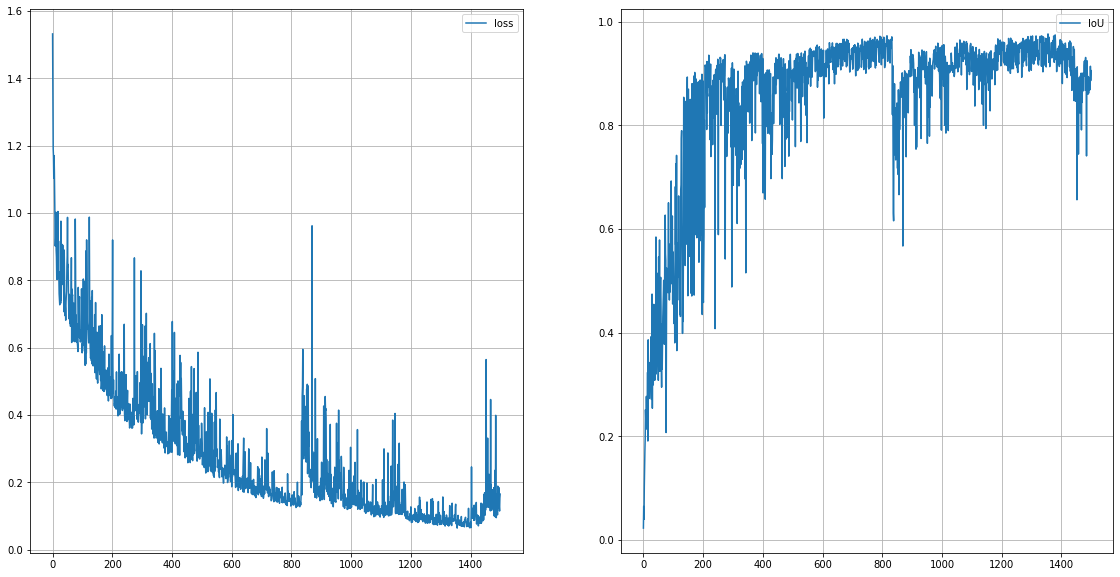

In [16]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(hist.history["loss"], label="loss")
#plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(hist.history["IoU"], label="IoU")
#plt.plot(hist.history["val_IoU"], label="val_IoU")
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir,'losscurve.png'))

save last epoch model, loss, and metrics,

In [17]:
model.save(os.path.join(out_dir,'final_epoch.h5'))
for key in sorted(hist.history.keys()):
    np.savetxt(os.path.join(out_dir,key+'.txt'),np.array(hist.history[key]))
